In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.manifold import TSNE
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [2]:
# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [3]:
RESULTS_FILE = os.path.join(INPUT_FOLDER, "filtered_results.csv")
df = pd.read_csv(RESULTS_FILE)
df.head(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,H2S_ppm,NH3_ppm
0,0.001,0.001,0.998,450000.0,710000.0,1416.62430,29.943006
1,0.001,0.001,0.998,450000.0,720000.0,1416.62433,29.942810
2,0.001,0.001,0.998,450000.0,730000.0,1416.62424,29.942868
3,0.001,0.001,0.998,450000.0,740000.0,1416.62432,29.942803
4,0.001,0.001,0.998,450000.0,750000.0,1416.62467,29.942809


In [4]:
print('Data rows:', df.shape[0])

Data rows: 81564


In [5]:
# Observing data tail
df.tail(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,H2S_ppm,NH3_ppm
81559,0.0091,0.0046,0.9863,490000.0,1090000.0,0.003559,1.691355
81560,0.0091,0.0028,0.9881,550000.0,1200000.0,0.002349,1.614418
81561,0.0091,0.0046,0.9863,590000.0,1030000.0,0.017424,3.330615
81562,0.0082,0.0028,0.9890,480000.0,830000.0,5.763264,76.771029
81563,0.0091,0.0037,0.9872,480000.0,980000.0,0.157615,8.449645


In [6]:
# Observing a sample
SAMPLE_SIZE = 5
start = np.random.randint(0, len(df) - SAMPLE_SIZE + 1)
sample_df = df.iloc[start : start + SAMPLE_SIZE]

sample_df.head(SAMPLE_SIZE)

,feedNH3,feedH2S,feedH20,QN1,QN2,H2S_ppm,NH3_ppm
2226,0.001,0.0028,0.9962,560000.0,1050000.0,0.000697,0.977672
2227,0.001,0.0028,0.9962,560000.0,1060000.0,0.000676,0.925533
2228,0.001,0.0028,0.9962,560000.0,1070000.0,0.000598,0.907714
2229,0.001,0.0028,0.9962,560000.0,1080000.0,0.000523,0.891026
2230,0.001,0.0028,0.9962,560000.0,1090000.0,0.000499,0.852851


In [7]:
df.describe()

,feedNH3,feedH2S,feedH20,QN1,QN2,H2S_ppm,NH3_ppm
count,81564.000000,81564.000000,81564.000000,81564.000000,8.156400e+04,8.156400e+04,8.156400e+04
mean,0.005049,0.005050,0.989901,524996.444510,9.499935e+05,4.240849e+03,8.084935e+01
std,0.002585,0.002585,0.003656,46096.435517,1.471971e+05,1.120334e+04,6.635889e+03
min,0.001000,0.001000,0.981800,450000.000000,7.000000e+05,2.131274e-13,5.639897e-10
25%,0.002800,0.002800,0.987200,480000.000000,8.200000e+05,3.446050e-01,1.960597e-03
50%,0.004600,0.005500,0.989900,520000.000000,9.500000e+05,1.433901e+03,6.109689e+00
75%,0.007300,0.007300,0.992600,560000.000000,1.080000e+06,7.407968e+03,2.153534e+01
max,0.009100,0.009100,0.998000,600000.000000,1.200000e+06,9.999926e+05,1.000000e+06


In [8]:
# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

# Check for zero values
zero_check = (df == 0).sum()
print("\nZero values per column:\n", zero_check)


NaN values per column:
 feedNH3    0
feedH2S    0
feedH20    0
QN1        0
QN2        0
H2S_ppm    0
NH3_ppm    0
dtype: int64

Zero values per column:
 feedNH3    0
feedH2S    0
feedH20    0
QN1        0
QN2        0
H2S_ppm    0
NH3_ppm    0
dtype: int64


In [9]:
# Filter rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print("Rows with NaN values:\n", nan_rows)


Rows with NaN values:
 Empty DataFrame
Columns: [feedNH3, feedH2S, feedH20, QN1, QN2, H2S_ppm, NH3_ppm]
Index: []


In [10]:
# Drop rows with any NaN values
df = df.dropna()

# Optionally, reset the index if needed
df = df.reset_index(drop=True)

# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

NaN values per column:
 feedNH3    0
feedH2S    0
feedH20    0
QN1        0
QN2        0
H2S_ppm    0
NH3_ppm    0
dtype: int64


In [12]:
# Separate features and labels from original df first
df_x = df.iloc[:, :-2]  # All columns except last two
df_y = df.iloc[:, -2:]  # Only last two columns

scaler_x = PowerTransformer()
scaler_y = PowerTransformer()

df_scaled_x = pd.DataFrame(scaler_x.fit_transform(df_x), 
                           columns=df_x.columns, 
                           index=df_x.index)

df_scaled_y = pd.DataFrame(scaler_y.fit_transform(df_y),
                           columns=df_y.columns,
                           index=df_y.index)

df_scaled = df_scaled_x.join(df_scaled_y)

print("Scaled DataFrames created successfully!")

Scaled DataFrames created successfully!


In [13]:
# Export the scaled dataframe using joblib
joblib.dump(df_scaled_x, os.path.join(INPUT_FOLDER, 'df3_scaled_x.joblib'))
joblib.dump(df_scaled_y, os.path.join(INPUT_FOLDER, 'df3_scaled_y.joblib'))

# Export the scalers using joblib
joblib.dump(scaler_x, os.path.join(INPUT_FOLDER, 'scaler3_x.joblib'))
joblib.dump(scaler_y, os.path.join(INPUT_FOLDER, 'scaler3_y.joblib'))

print("Data and scalers exported successfully to the input files folder!")

Data and scalers exported successfully to the input files folder!


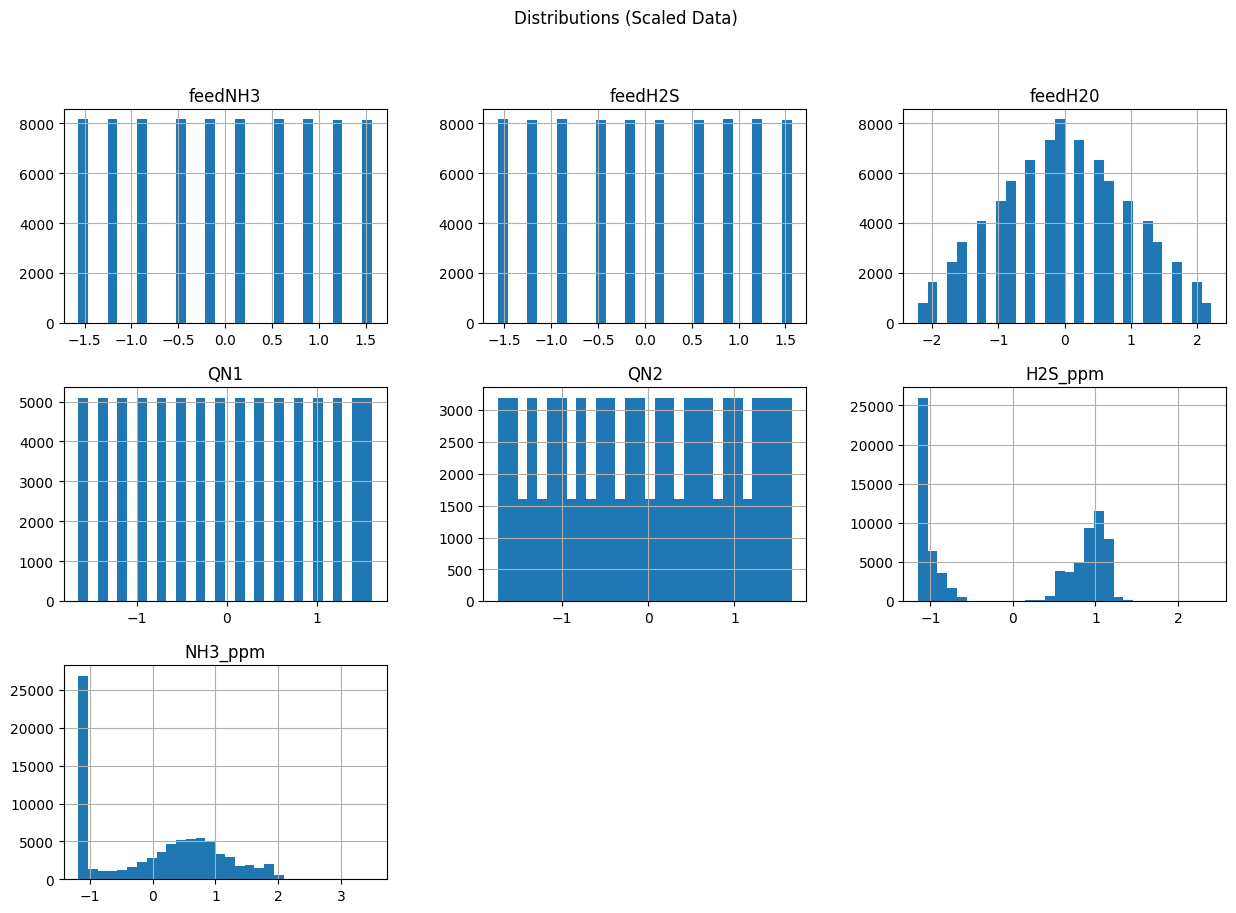

In [14]:
# Data Distribution and Descriptive Statistics
# Histograms for each feature in df_scaled_x
df_scaled.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions (Scaled Data)")
plt.show()

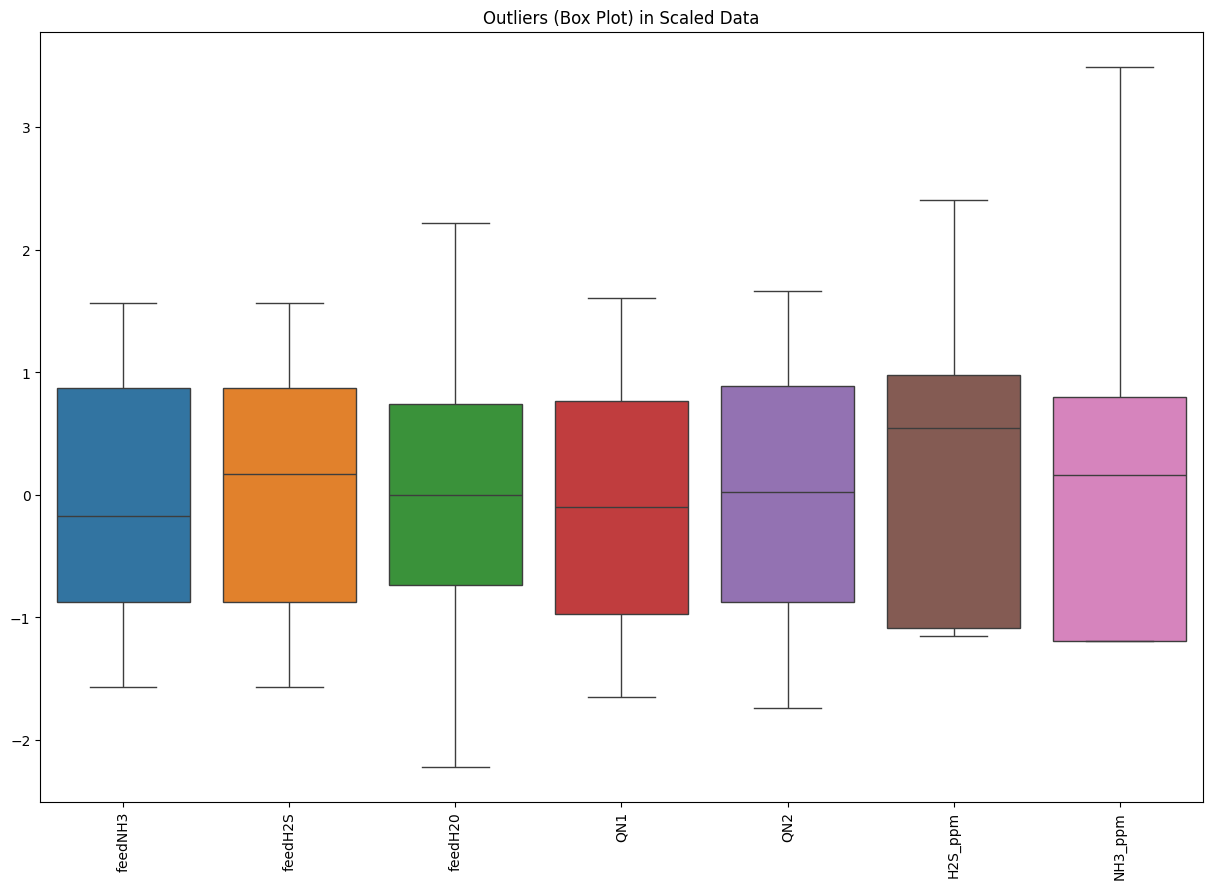

In [15]:
# Box plots to check for outliers in df_scaled_x
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=90)
plt.title("Outliers (Box Plot) in Scaled Data")
plt.show()

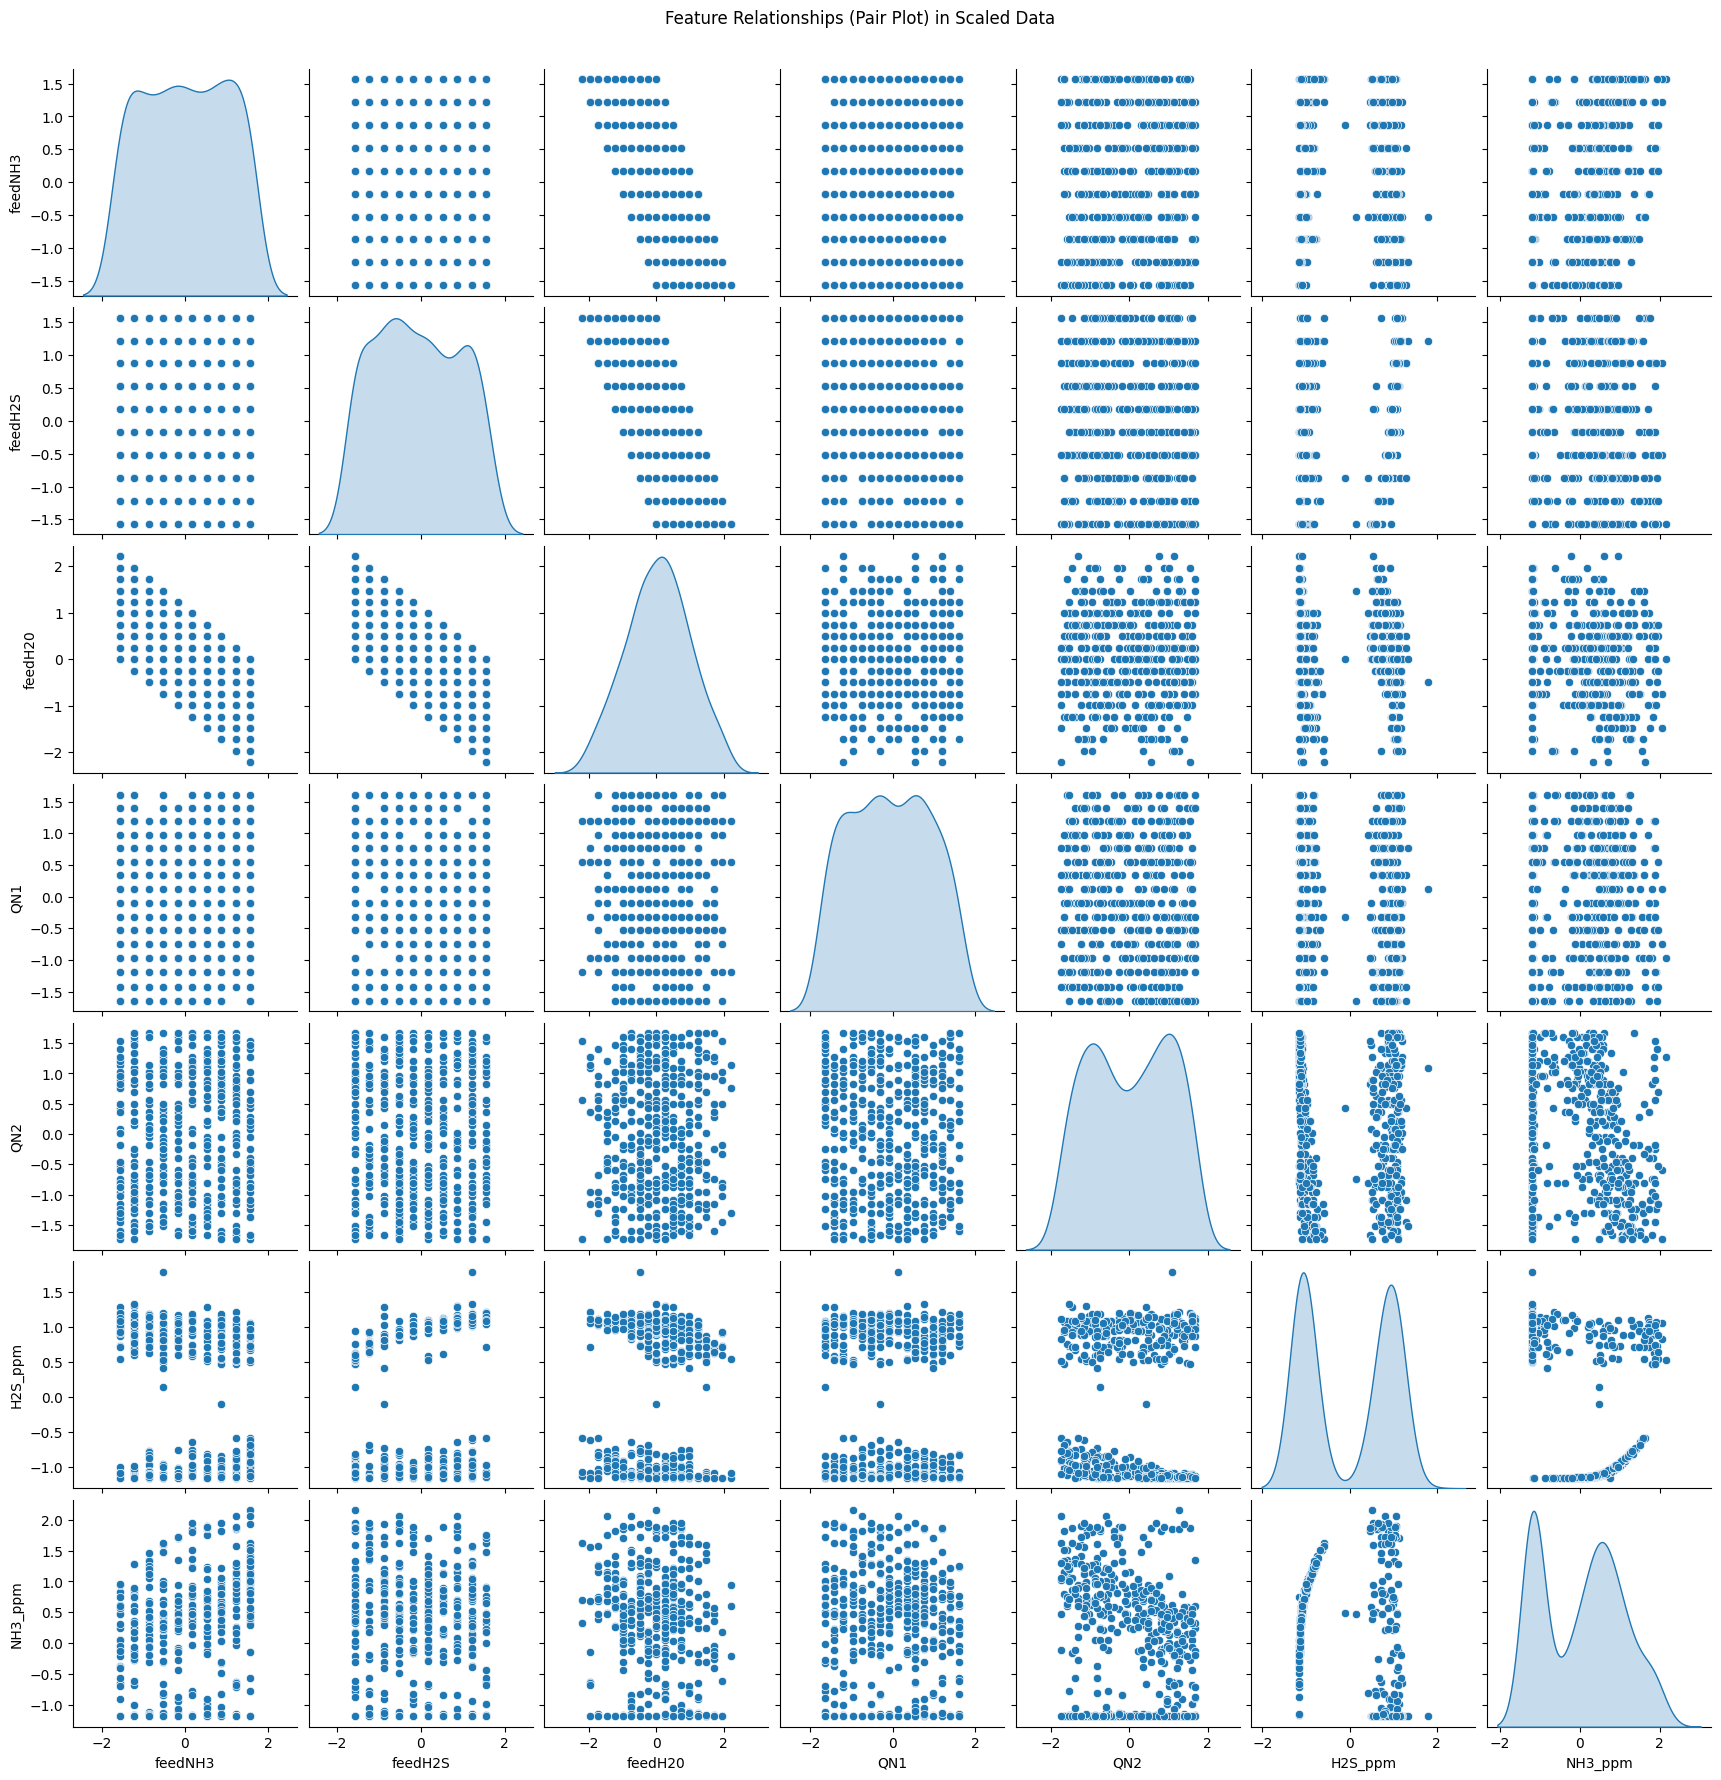

In [16]:
# Pair Plot (if data size is manageable)
sns.pairplot(df_scaled.sample(n=min(500, len(df_scaled))), diag_kind='kde')
plt.suptitle("Feature Relationships (Pair Plot) in Scaled Data", y=1.02)
plt.show()

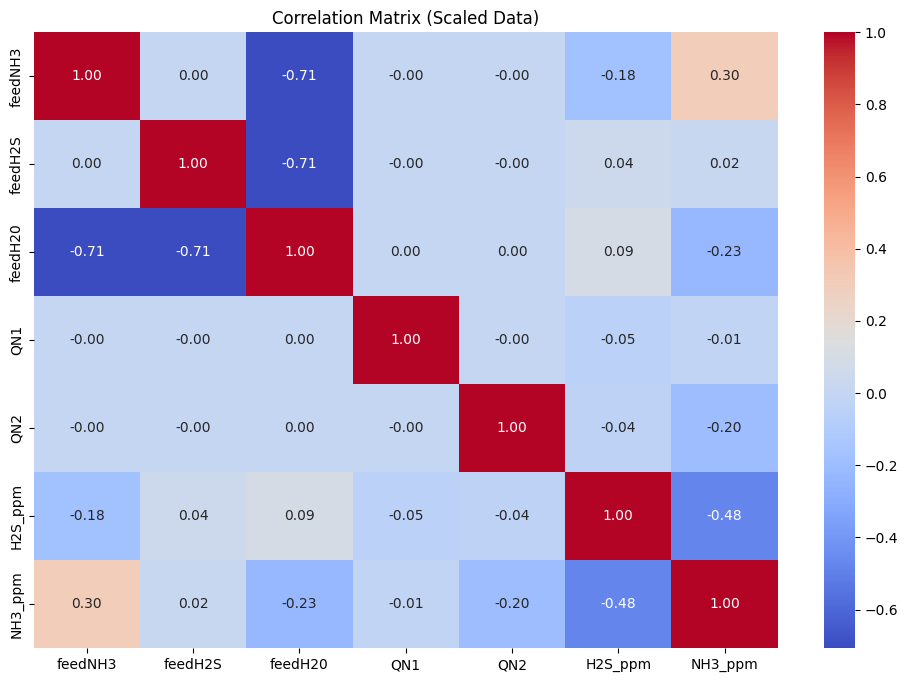

In [17]:
# Correlation Analysis
# Heatmap for Correlation Matrix in df_scaled_x
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Scaled Data)")
plt.show()